## Text Pattern Analysis Techniques ##

*compiled and/or coded by Jon Puryear*

In [1]:
#Import the external packages into Python to perform various analyses
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import punkt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import json
import pymssql as pym

**Import Custom Functions**

cleanString, createStopWords, fileDataLoad, WarehouseDataExtract

In [2]:
#import custom functions
from cleanString import cleanString
from createStopWords import createStopWords
from fileDataLoad import fileDataLoad

**Collect Raw Data**

In [3]:
# using my test star wars dataset - if this was a real analysis you would use another source file, 
# either from Excel, CSV or the AMS Warehouse using WarehouseData Extract
filename = r'C:\Users\jpuryear1\Documents\Python Scripts\starwars_data.xlsx'
sheetname = 'Sheet1'

In [4]:
inputDF = fileDataLoad(filename,sheetname)

In [5]:
print(inputDF.head())

                  Title                                            Summary
0    The Phantom Menace  Two Jedi Knights escape a hostile blockade to ...
1  Attack of the Clones  Ten years after initially meeting, Anakin Skyw...
2   Revenge of the Sith  Three years into the Clone Wars, the Jedi resc...
3                  Solo  During an adventure into the criminal underwor...
4             Rogue One  The daughter of an Imperial scientist joins th...


In [6]:
# Create a Backup version of the Input Dataframe for testing purposes...
inputBU = inputDF.copy()

### Transform the Text Data ###

Extract the Text data from the dataframe, clean the Text, Tokenize the Text and insert back into the Input Dataframe

**Clean the Text Strings**

Dumps the 'Summary' data into a list, runs the CleanString() function on all the words and adds a "Clean Text" column back into the input dataframe

In [7]:
# Extract the Summary data from the dataframe into a list
TextReviewList = inputDF.loc[:,'Summary'].tolist()

#Create a "clean" list to hold the cleaned strings
TextCleanList = []

# Clean the strings from TextReviewList and copy the clean strings to TextCleanList
for str in TextReviewList:
    TextCleanList.append(cleanString(str))
    
# adds a new column to the inputDF to hold the cleaned summary text
inputDF['CleanText'] = ''

# merge the cleaned summary back into the input dataframe
inputDF['CleanText'] = pd.Series(TextCleanList).values

In [8]:
# Uncomment the print statement if you want to check on the progress...
# print(inputDF)

## Convert the CleanText sentences into Word Tokens ##

**Count Vectorizer**

Counts the # of times a word appears in a given row

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
#Instantiates the Count Vectorizer
cvec = CountVectorizer(lowercase=True)

# convert the documents into a document-term matrix
count_matrix = cvec.fit_transform(TextCleanList)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from a word matrix
def count2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

# create a dataframe from the matrix
word_df = count2df(count_matrix, tokens)

# Adds a new row called 'sum' and adds up the word counts by column
word_df.loc['sum'] = word_df.sum()

#transpose the Dataframe - so that words are the rows so we can sum the count of words across all documents
word2_df = word_df.transpose()

#add a column to sum up each word across docs
word2_df['sum'] = word2_df[word2_df.columns].sum(axis=1)



In [10]:
# COLLAPSE THE DATAFRAME
#define the columns to drop - we want to drop the document columns
cols = word2_df.columns[0:-1]

#create a new dataframe with just Word and Sum
word3_df = word2_df.drop(cols, axis = 1) 

#sort the new dataframe by the sum of words
word3_df = word3_df.sort_values(by=['sum'], ascending=False)

print(word3_df)

              sum
the            64
to             22
and            14
jedi           12
luke           10
with           10
from           10
skywalker      10
into            8
after           8
of              6
years           6
by              6
empire          6
rescue          6
for             6
vader           6
while           6
are             6
darth           6
in              6
an              6
rey             4
death           4
resistance      4
rebels          4
meanwhile       4
first           4
palpatine       4
pilot           4
...           ...
initially       2
investigates    2
across          2
jabba           2
joining         2
kenobi          2
knight          2
knights         2
lando           2
future          2
friends         2
forces          2
during          2
discovered      2
discovers       2
dispatch        2
dooku           2
dormant         2
double          2
droids          2
emperor         2
force           2
encounters      2
endor     

**In development**

In [11]:
# create the Stop words to use
stopset = createStopWords('')

#need more information about what this does...
vectorizer = TfidfVectorizer(stop_words=stopset, analyzer = 'word')
#need more information about what this does...
tfidf_matrix = vectorizer.fit_transform(inputDF.loc[:,'CleanText'].tolist())

# break out the distinct words
feature_names = vectorizer.get_feature_names()
dense = tfidf_matrix.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)


In [30]:
# Prints where the count of a given word in a given doc is > 0
print(df.loc[:] > 0)

   abilities  across   acts  adventure  agent  alliance  allies   also  \
0      False    True  False      False  False     False    True  False   
1      False   False  False      False  False     False   False  False   
2      False   False   True      False   True     False   False  False   
3      False   False  False       True  False     False   False  False   
4      False   False  False      False  False      True   False  False   
5      False   False  False      False  False     False   False   True   
6      False   False  False      False  False     False   False  False   
7      False   False  False      False  False     False   False  False   
8      False   False  False      False  False     False   False  False   
9       True   False  False      False  False     False   False  False   

   amidala  anakin  ...    unsettled  vader    wan   wars  without  wookiee  \
0    False   False  ...        False  False  False  False    False    False   
1     True    True  ...    

**Frequency of Words**

Need to work through this section....

1) Convert Clean text to Tokens - append to Input Dataframe

2) Count the Frequency of the Tokens - append to Input Dataframe

TF-IDF

In [13]:
stopset = set(stopwords.words('english'))

In [14]:
# Extract the Summary data from the dataframe into a list
NewList = inputDF.loc[:,'CleanText'].tolist()

In [15]:
#Create a "clean" list to hold the cleaned strings
TextTokenList = []

In [16]:
for str in NewList:
    TextTokenList.append(word_tokenize(str))

In [17]:
for review in TextTokenList:
    for word in review:
        if word in stopset:
            review.remove(word)

In [18]:
print(TextTokenList)

[['two', 'jedi', 'knights', 'escape', 'hostile', 'blockade', 'find', 'allies', 'come', 'across', 'young', 'boy', 'may', 'bring', 'balance', 'the', 'force', 'the', 'long', 'dormant', 'sith', 'resurface', 'claim', 'old', 'glory'], ['ten', 'years', 'initially', 'meeting', 'anakin', 'skywalker', 'shares', 'forbidden', 'romance', 'padm', 'amidala', 'obi', 'wan', 'kenobi', 'investigates', 'assassination', 'attempt', 'the', 'senator', 'discovers', 'secret', 'clone', 'army', 'crafted', 'the', 'jedi'], ['three', 'years', 'clone', 'wars', 'jedi', 'rescue', 'palpatine', 'count', 'dooku', 'obi', 'wan', 'pursues', 'new', 'threat', 'anakin', 'acts', 'a', 'double', 'agent', 'the', 'jedi', 'council', 'palpatine', 'is', 'lured', 'a', 'sinister', 'plan', 'rule', 'the', 'galaxy'], ['an', 'adventure', 'criminal', 'underworld', 'han', 'solo', 'meets', 'future', 'co', 'pilot', 'chewbacca', 'encounters', 'lando', 'calrissian', 'years', 'joining', 'the', 'rebellion'], ['daughter', 'an', 'imperial', 'scientist

In [19]:
# adds a new column to the inputDF to hold the token text
inputDF['CleanToken'] = ''

# merge the token summary back into the input dataframe
inputDF['CleanToken'] = pd.Series(TextTokenList).values

In [20]:
print(inputDF)

                     Title                                            Summary  \
0       The Phantom Menace  Two Jedi Knights escape a hostile blockade to ...   
1     Attack of the Clones  Ten years after initially meeting, Anakin Skyw...   
2      Revenge of the Sith  Three years into the Clone Wars, the Jedi resc...   
3                     Solo  During an adventure into the criminal underwor...   
4                Rogue One  The daughter of an Imperial scientist joins th...   
5               A New Hope  Luke Skywalker joins forces with a Jedi Knight...   
6  The Empire Strikes Back  After the rebels are brutally overpowered by t...   
7       Return of the Jedi  After a daring mission to rescue Han Solo from...   
8        The Force Awakens  Three decades after the Empire's defeat, a new...   
9            The Last Jedi  Rey develops her newly discovered abilities wi...   

                                           CleanText  \
0  two jedi knights escape a hostile blockade to ...

In [21]:
FreqList = []
for lst in TextTokenList:
    for word in lst:
        FreqList.append(word)
        
print (FreqList)   

['two', 'jedi', 'knights', 'escape', 'hostile', 'blockade', 'find', 'allies', 'come', 'across', 'young', 'boy', 'may', 'bring', 'balance', 'the', 'force', 'the', 'long', 'dormant', 'sith', 'resurface', 'claim', 'old', 'glory', 'ten', 'years', 'initially', 'meeting', 'anakin', 'skywalker', 'shares', 'forbidden', 'romance', 'padm', 'amidala', 'obi', 'wan', 'kenobi', 'investigates', 'assassination', 'attempt', 'the', 'senator', 'discovers', 'secret', 'clone', 'army', 'crafted', 'the', 'jedi', 'three', 'years', 'clone', 'wars', 'jedi', 'rescue', 'palpatine', 'count', 'dooku', 'obi', 'wan', 'pursues', 'new', 'threat', 'anakin', 'acts', 'a', 'double', 'agent', 'the', 'jedi', 'council', 'palpatine', 'is', 'lured', 'a', 'sinister', 'plan', 'rule', 'the', 'galaxy', 'an', 'adventure', 'criminal', 'underworld', 'han', 'solo', 'meets', 'future', 'co', 'pilot', 'chewbacca', 'encounters', 'lando', 'calrissian', 'years', 'joining', 'the', 'rebellion', 'daughter', 'an', 'imperial', 'scientist', 'joins

In [22]:
CleanFreqList = []
for word in FreqList:
    if word not in stopset:
            CleanFreqList.append(word)    

In [23]:
print(CleanFreqList)

['two', 'jedi', 'knights', 'escape', 'hostile', 'blockade', 'find', 'allies', 'come', 'across', 'young', 'boy', 'may', 'bring', 'balance', 'force', 'long', 'dormant', 'sith', 'resurface', 'claim', 'old', 'glory', 'ten', 'years', 'initially', 'meeting', 'anakin', 'skywalker', 'shares', 'forbidden', 'romance', 'padm', 'amidala', 'obi', 'wan', 'kenobi', 'investigates', 'assassination', 'attempt', 'senator', 'discovers', 'secret', 'clone', 'army', 'crafted', 'jedi', 'three', 'years', 'clone', 'wars', 'jedi', 'rescue', 'palpatine', 'count', 'dooku', 'obi', 'wan', 'pursues', 'new', 'threat', 'anakin', 'acts', 'double', 'agent', 'jedi', 'council', 'palpatine', 'lured', 'sinister', 'plan', 'rule', 'galaxy', 'adventure', 'criminal', 'underworld', 'han', 'solo', 'meets', 'future', 'co', 'pilot', 'chewbacca', 'encounters', 'lando', 'calrissian', 'years', 'joining', 'rebellion', 'daughter', 'imperial', 'scientist', 'joins', 'rebel', 'alliance', 'risky', 'move', 'steal', 'death', 'star', 'plans', '

In [24]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [27]:
CleanFreqString = ' '.join(CleanFreqList)

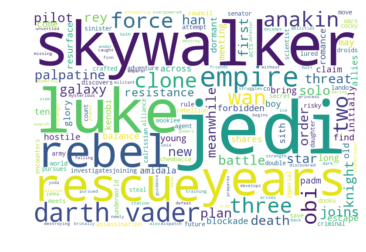

In [28]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopset, background_color="white", height = 500, width = 750).generate(CleanFreqString)
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()